This notebook is simpified version of the final project in the [How to Win a Data Science Competition: Learn from Top Kagglers](https://www.coursera.org/learn/competitive-data-science) course. Simplified means without ensembling.

#### Pipline
* load data
* heal data and remove outliers
* work with shops/items/cats objects and features
* create matrix as product of item/shop pairs within each month in the train set
* get monthly sales for each item/shop pair in the train set and merge it to the matrix
* clip item_cnt_month by (0,20)
* append test to the matrix, fill 34 month nans with zeros
* merge shops/items/cats to the matrix
* add target lag features
* add mean encoded features
* add price trend features
* add month
* add days
* add months since last sale/months since first sale features
* cut first year and drop columns which can not be calculated for the test set
* select best features
* set validation strategy 34 test, 33 validation, less than 33 train
* fit the model, predict and clip targets for the test set

# Part 1, perfect features

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys
import gc
import pickle
sys.version_info

sys.version_info(major=3, minor=5, micro=2, releaselevel='final', serial=0)

In [35]:
items = pd.read_csv('../input/items.csv')
shops = pd.read_csv('../input/shops.csv')
cats = pd.read_csv('../input/item_categories.csv')
train = pd.read_csv('../input/sales_train.csv')
# set index to ID to avoid droping it later
test  = pd.read_csv('../input/test.csv').set_index('ID')

## Outliers

There are items with strange prices and sales. After detailed exploration I decided to remove items with price > 100000 and sales > 1001 (1000 is ok).

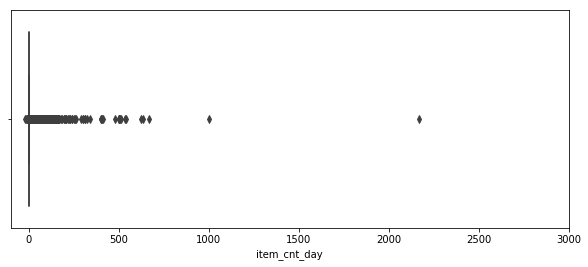

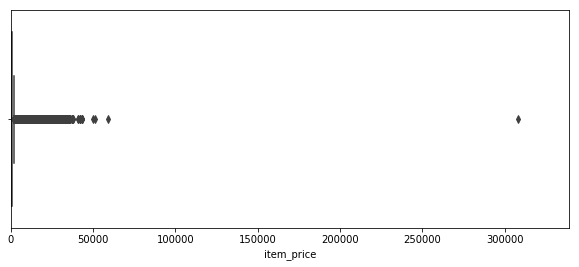

In [3]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [4]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

There is one item with price below zero. Fill it with median.

In [5]:
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

Several shops are duplicates of each other (according to its name). Fix train and test set.

In [6]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

## Shops/Cats/Items preprocessing
Observations:
* Each shop_name starts with the city name.
* Each category contains type and subtype in its name.

In [7]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

cats['split'] = cats['item_category_name'].str.split('-')
cats['type'] = cats['split'].map(lambda x: x[0].strip())
cats['type_code'] = LabelEncoder().fit_transform(cats['type'])
# if subtype is nan then type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])
cats = cats[['item_category_id','type_code', 'subtype_code']]

items.drop(['item_name'], axis=1, inplace=True)

In [8]:
cats

,item_category_id,type_code,subtype_code
0,0,0,29
1,1,1,9
2,2,1,10
3,3,1,11
4,4,1,13
5,5,1,14
6,6,1,16
7,7,1,17
8,8,2,26
9,9,3,33


## Monthly sales
Test set is a product of some shops and some items within 34 month. There are 5100 items * 42 shops = 214200 pairs. 363 items are new compared to the train. Hence, for the most of the items in the test set target value should be zero. 
In the other hand train set contains only pairs which were sold or returned in the past. Tha main idea is to calculate monthly sales and <b>extend it with zero sales</b> for each unique pair within the month. This way train data will be similar to test data.

In [9]:
len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))), len(list(set(test.item_id))), len(test)

(363, 5100, 214200)

In [10]:
ts = time.time()
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
time.time() - ts

12.029033899307251

Aggregate train set by shop/item pairs to calculate target aggreagates, then <b>clip(0,20)</b> target value. This way train target will be similar to the test predictions.

<i>I use floats instead of ints for item_cnt_month to avoid downcasting it after concatination with the test set later. If it would be int16, after concatination with NaN values it becomes int64, but foat16 becomes float16 even with NaNs.</i>

In [11]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']

In [12]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))
time.time() - ts

5.771673917770386

## Test set
To use time tricks append test pairs to the matrix.

In [13]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [14]:
ts = time.time()
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month
time.time() - ts

0.08576107025146484

## Shops/Items/Cats features

In [15]:
ts = time.time()
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
time.time() - ts

4.915248870849609

In [16]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code
0,0,2,19,0.0,0,40,11,4
1,0,2,27,1.0,0,19,5,10
2,0,2,28,0.0,0,30,8,55
3,0,2,29,0.0,0,23,5,16
4,0,2,32,0.0,0,40,11,4
5,0,2,33,1.0,0,37,11,1
6,0,2,34,0.0,0,40,11,4
7,0,2,35,0.0,0,40,11,4
8,0,2,40,0.0,0,57,13,8
9,0,2,41,0.0,0,57,13,8


## Traget lags

In [17]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [18]:
ts = time.time()
matrix = lag_feature(matrix, [1,2,3,4,5,6,7,8,9,10,11,12], 'item_cnt_month')
time.time() - ts

86.63061285018921

In [19]:
matrix[matrix.date_block_num == 3]


,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,item_cnt_month_lag_7,item_cnt_month_lag_8,item_cnt_month_lag_9,item_cnt_month_lag_10,item_cnt_month_lag_11,item_cnt_month_lag_12
1122795,3,2,27,0.0,0,19,5,10,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1122796,3,2,28,0.0,0,30,8,55,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1122797,3,2,30,0.0,0,40,11,4,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1122798,3,2,31,1.0,0,37,11,1,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1122799,3,2,32,0.0,0,40,11,4,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1122800,3,2,33,0.0,0,37,11,1,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1122801,3,2,34,0.0,0,40,11,4,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1122802,3,2,36,0.0,0,37,11,1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1122803,3,2,37,0.0,0,40,11,4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1122804,3,2,40,0.0,0,57,13,8,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Mean encoded features

In [20]:
ts = time.time()
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

12.02240514755249

In [21]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,4,5,6,7,8,9,10,11,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

99.12456226348877

In [22]:
matrix

,date_block_num,shop_id,item_id,item_cnt_month,city_code,item_category_id,type_code,subtype_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_4,item_cnt_month_lag_5,item_cnt_month_lag_6,item_cnt_month_lag_7,item_cnt_month_lag_8,item_cnt_month_lag_9,item_cnt_month_lag_10,item_cnt_month_lag_11,item_cnt_month_lag_12,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_item_avg_item_cnt_lag_4,date_item_avg_item_cnt_lag_5,date_item_avg_item_cnt_lag_6,date_item_avg_item_cnt_lag_7,date_item_avg_item_cnt_lag_8,date_item_avg_item_cnt_lag_9,date_item_avg_item_cnt_lag_10,date_item_avg_item_cnt_lag_11,date_item_avg_item_cnt_lag_12
0,0,2,19,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,2,27,1.0,0,19,5,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,2,28,0.0,0,30,8,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,29,0.0,0,23,5,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,2,32,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0,2,33,1.0,0,37,11,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0,2,34,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0,2,35,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0,2,40,0.0,0,57,13,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0,2,41,0.0,0,57,13,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,4,5,6,7,8,9,10,11,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

103.47814607620239

In [24]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left') 
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

17.229110956192017

In [25]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

17.874589204788208

In [26]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

17.955823183059692

In [27]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

18.54679298400879

In [28]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

18.057411193847656

In [32]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

27.76089119911194

In [33]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

18.598824977874756

In [34]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

19.023585081100464

## Trend features

Price trend for the last six months.

In [35]:
ts = time.time()
group = train.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price')

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']


In [36]:

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0
    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

# https://stackoverflow.com/questions/31828240/first-non-null-value-per-row-from-a-list-of-pandas-columns/31828559
# matrix['price_trend'] = matrix[['delta_price_lag_1','delta_price_lag_2','delta_price_lag_3']].bfill(axis=1).iloc[:, 0]
# Invalid dtype for backfill_2d [float16]

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

time.time() - ts

475.60366582870483

Last month shop revenue trend

In [37]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)
time.time() - ts

22.40481162071228

In [38]:
matrix['month'] = matrix['date_block_num'] % 12

Number of days in a month. There are no leap years.

In [39]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)

Months since the last sale for each shop/item pair and for item only. I use programing approach.

<i>Create HashTable with key equals to {shop_id,item_id} and value equals to date_block_num. Iterate data from the top. Foreach row if {row.shop_id,row.item_id} is not present in the table, then add it to the table and set its value to row.date_block_num. if HashTable contains key, then calculate the difference beteween cached value and row.date_block_num.</i>

In [40]:
ts = time.time()
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num         
time.time() - ts

1951.6218078136444

In [41]:
ts = time.time()
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            if row.item_cnt_month!=0:
                cache[key] = row.date_block_num         
time.time() - ts

1535.6713979244232

Months since the first sale for each shop/item pair and for item only.

In [42]:
ts = time.time()
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')
time.time() - ts

2.228188991546631

## Final preparations
Because of the using 12 as lag value drop first 12 months. Also drop all the columns with this month calculated values (other words which can not be calcucated for the test set).

In [43]:
ts = time.time()
#matrix = matrix[matrix.date_block_num > 11]
time.time() - ts

3.790855407714844e-05

Producing lags brings a lot of nulls.

In [44]:
ts = time.time()
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)
time.time() - ts

11.322792053222656

In [45]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city_code',
       'item_category_id', 'type_code', 'subtype_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_4',
       'item_cnt_month_lag_5', 'item_cnt_month_lag_6', 'item_cnt_month_lag_7',
       'item_cnt_month_lag_8', 'item_cnt_month_lag_9', 'item_cnt_month_lag_10',
       'item_cnt_month_lag_11', 'item_cnt_month_lag_12',
       'date_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_2', 'date_item_avg_item_cnt_lag_3',
       'date_item_avg_item_cnt_lag_4', 'date_item_avg_item_cnt_lag_5',
       'date_item_avg_item_cnt_lag_6', 'date_item_avg_item_cnt_lag_7',
       'date_item_avg_item_cnt_lag_8', 'date_item_avg_item_cnt_lag_9',
       'date_item_avg_item_cnt_lag_10', 'date_item_avg_item_cnt_lag_11',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_av

In [46]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128004 entries, 0 to 11128003
Data columns (total 63 columns):
date_block_num                          int8
shop_id                                 int8
item_id                                 int16
item_cnt_month                          float16
city_code                               int8
item_category_id                        int8
type_code                               int8
subtype_code                            int8
item_cnt_month_lag_1                    float16
item_cnt_month_lag_2                    float16
item_cnt_month_lag_3                    float16
item_cnt_month_lag_4                    float16
item_cnt_month_lag_5                    float16
item_cnt_month_lag_6                    float16
item_cnt_month_lag_7                    float16
item_cnt_month_lag_8                    float16
item_cnt_month_lag_9                    float16
item_cnt_month_lag_10                   float16
item_cnt_month_lag_11                   f

In [47]:
matrix.to_pickle('data.pkl')
del matrix
del cache
del group
del items
del shops
del cats
del train
# leave test for submission
gc.collect();

# Part 2, xgboost

In [36]:
data = pd.read_pickle('data.pkl')

In [37]:
data.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city_code',
       'item_category_id', 'type_code', 'subtype_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_4',
       'item_cnt_month_lag_5', 'item_cnt_month_lag_6', 'item_cnt_month_lag_7',
       'item_cnt_month_lag_8', 'item_cnt_month_lag_9', 'item_cnt_month_lag_10',
       'item_cnt_month_lag_11', 'item_cnt_month_lag_12',
       'date_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_2', 'date_item_avg_item_cnt_lag_3',
       'date_item_avg_item_cnt_lag_4', 'date_item_avg_item_cnt_lag_5',
       'date_item_avg_item_cnt_lag_6', 'date_item_avg_item_cnt_lag_7',
       'date_item_avg_item_cnt_lag_8', 'date_item_avg_item_cnt_lag_9',
       'date_item_avg_item_cnt_lag_10', 'date_item_avg_item_cnt_lag_11',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_av

Select perfect features

In [38]:
data = data[data.date_block_num > 5]
data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    # 'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_4',
    'item_cnt_month_lag_5',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_7',
    'item_cnt_month_lag_8',
    'item_cnt_month_lag_9',
    'item_cnt_month_lag_10',
    'item_cnt_month_lag_11',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_4',
    'date_item_avg_item_cnt_lag_5',
    'date_item_avg_item_cnt_lag_6',
    # 'date_item_avg_item_cnt_lag_7',
    # 'date_item_avg_item_cnt_lag_8',
    # 'date_item_avg_item_cnt_lag_9',
    # 'date_item_avg_item_cnt_lag_10',
    # 'date_item_avg_item_cnt_lag_11',
    # 'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_4',
    'date_shop_avg_item_cnt_lag_5',
    'date_shop_avg_item_cnt_lag_6',
    # 'date_shop_avg_item_cnt_lag_7',
    # 'date_shop_avg_item_cnt_lag_8',
    # 'date_shop_avg_item_cnt_lag_9',
    # 'date_shop_avg_item_cnt_lag_10',
    # 'date_shop_avg_item_cnt_lag_11',
    # 'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    # 'date_shop_type_avg_item_cnt_lag_1',
    # 'date_shop_subtype_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    # 'date_type_avg_item_cnt_lag_1',
    # 'date_subtype_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
    # 'item_shop_last_sale',
    # 'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]]

Validation strategy is 34 month for the test set, 33 month for the validation set and 13-33 months for the train.

In [39]:
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [18]:
from sklearn.utils import shuffle
import numpy as np

# X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
# Y_train = data[data.date_block_num < 33]['item_cnt_month']
# X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
# Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)
data = data[data.date_block_num < 33]

shuffle_data = shuffle(data)
shuffle_data.reset_index(drop=True, inplace=True)
X_train = shuffle_data.loc[:np.round(0.8 * len(data))].drop(['item_cnt_month'], axis=1)
Y_train = shuffle_data.loc[:np.round(0.8 * len(data))]['item_cnt_month']
X_valid = shuffle_data.loc[np.round(0.8 * len(data)):len(data)].drop(['item_cnt_month'], axis=1)
Y_valid = shuffle_data.loc[np.round(0.8 * len(data)):len(data)]['item_cnt_month']

In [19]:
del data
gc.collect();

In [20]:
ts = time.time()

model = XGBRegressor(
    max_depth=8,
    n_estimators=3000,
    n_jobs=16,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

/home/p76071412/letticee/lib/python3.5/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/p76071412/letticee/lib/python3.5/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	validation_0-rmse:1.18872	validation_1-rmse:1.18331
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.14094	validation_1-rmse:1.13621
[2]	validation_0-rmse:1.10026	validation_1-rmse:1.09607
[3]	validation_0-rmse:1.06795	validation_1-rmse:1.06407
[4]	validation_0-rmse:1.03911	validation_1-rmse:1.03551
[5]	validation_0-rmse:1.0137	validation_1-rmse:1.01035
[6]	validation_0-rmse:0.992417	validation_1-rmse:0.989285
[7]	validation_0-rmse:0.975236	validation_1-rmse:0.972321
[8]	validation_0-rmse:0.959635	validation_1-rmse:0.956961
[9]	validation_0-rmse:0.947827	validation_1-rmse:0.945222
[10]	validation_0-rmse:0.936107	validation_1-rmse:0.933648
[11]	validation_0-rmse:0.927042	validation_1-rmse:0.924697
[12]	validation_0-rmse:0.918853	validation_1-rmse:0.916675
[13]	validation_0-rmse:0.911612	validation_1-rmse:0.90962
[14]	validation_0-rmse:0.905605	validat

[137]	validation_0-rmse:0.826678	validation_1-rmse:0.830084
[138]	validation_0-rmse:0.826517	validation_1-rmse:0.829984
[139]	validation_0-rmse:0.826161	validation_1-rmse:0.829629
[140]	validation_0-rmse:0.825979	validation_1-rmse:0.829503
[141]	validation_0-rmse:0.825777	validation_1-rmse:0.829356
[142]	validation_0-rmse:0.825526	validation_1-rmse:0.829105
[143]	validation_0-rmse:0.825421	validation_1-rmse:0.829032
[144]	validation_0-rmse:0.825334	validation_1-rmse:0.828974
[145]	validation_0-rmse:0.825244	validation_1-rmse:0.828931
[146]	validation_0-rmse:0.825137	validation_1-rmse:0.828857
[147]	validation_0-rmse:0.824958	validation_1-rmse:0.828691
[148]	validation_0-rmse:0.824629	validation_1-rmse:0.828368
[149]	validation_0-rmse:0.824512	validation_1-rmse:0.828288
[150]	validation_0-rmse:0.824359	validation_1-rmse:0.828129
[151]	validation_0-rmse:0.824255	validation_1-rmse:0.828064
[152]	validation_0-rmse:0.823404	validation_1-rmse:0.827283
[153]	validation_0-rmse:0.823241	validat

[275]	validation_0-rmse:0.808619	validation_1-rmse:0.816539
[276]	validation_0-rmse:0.808552	validation_1-rmse:0.81651
[277]	validation_0-rmse:0.808483	validation_1-rmse:0.81649
[278]	validation_0-rmse:0.808456	validation_1-rmse:0.816485
[279]	validation_0-rmse:0.808343	validation_1-rmse:0.81643
[280]	validation_0-rmse:0.808141	validation_1-rmse:0.816228
[281]	validation_0-rmse:0.808075	validation_1-rmse:0.816179
[282]	validation_0-rmse:0.808011	validation_1-rmse:0.816146
[283]	validation_0-rmse:0.807964	validation_1-rmse:0.816112
[284]	validation_0-rmse:0.807898	validation_1-rmse:0.816057
[285]	validation_0-rmse:0.807836	validation_1-rmse:0.816024
[286]	validation_0-rmse:0.807767	validation_1-rmse:0.815982
[287]	validation_0-rmse:0.807703	validation_1-rmse:0.815973
[288]	validation_0-rmse:0.807657	validation_1-rmse:0.815954
[289]	validation_0-rmse:0.807597	validation_1-rmse:0.815931
[290]	validation_0-rmse:0.807567	validation_1-rmse:0.815936
[291]	validation_0-rmse:0.807531	validation

[413]	validation_0-rmse:0.798042	validation_1-rmse:0.810105
[414]	validation_0-rmse:0.798021	validation_1-rmse:0.810098
[415]	validation_0-rmse:0.797998	validation_1-rmse:0.810105
[416]	validation_0-rmse:0.797983	validation_1-rmse:0.810105
[417]	validation_0-rmse:0.797948	validation_1-rmse:0.81008
[418]	validation_0-rmse:0.797903	validation_1-rmse:0.810073
[419]	validation_0-rmse:0.797835	validation_1-rmse:0.81005
[420]	validation_0-rmse:0.79779	validation_1-rmse:0.81004
[421]	validation_0-rmse:0.797744	validation_1-rmse:0.810039
[422]	validation_0-rmse:0.797697	validation_1-rmse:0.81001
[423]	validation_0-rmse:0.797641	validation_1-rmse:0.809971
[424]	validation_0-rmse:0.79758	validation_1-rmse:0.809946
[425]	validation_0-rmse:0.797551	validation_1-rmse:0.809927
[426]	validation_0-rmse:0.797506	validation_1-rmse:0.809902
[427]	validation_0-rmse:0.797456	validation_1-rmse:0.809883
[428]	validation_0-rmse:0.797413	validation_1-rmse:0.809859
[429]	validation_0-rmse:0.797387	validation_1-

[551]	validation_0-rmse:0.789475	validation_1-rmse:0.805223
[552]	validation_0-rmse:0.789442	validation_1-rmse:0.805197
[553]	validation_0-rmse:0.789383	validation_1-rmse:0.805163
[554]	validation_0-rmse:0.789349	validation_1-rmse:0.80516
[555]	validation_0-rmse:0.789293	validation_1-rmse:0.805148
[556]	validation_0-rmse:0.789256	validation_1-rmse:0.80514
[557]	validation_0-rmse:0.789234	validation_1-rmse:0.805144
[558]	validation_0-rmse:0.789215	validation_1-rmse:0.805131
[559]	validation_0-rmse:0.789174	validation_1-rmse:0.805137
[560]	validation_0-rmse:0.789139	validation_1-rmse:0.805135
[561]	validation_0-rmse:0.789114	validation_1-rmse:0.805133
[562]	validation_0-rmse:0.789087	validation_1-rmse:0.805125
[563]	validation_0-rmse:0.789046	validation_1-rmse:0.805103
[564]	validation_0-rmse:0.789008	validation_1-rmse:0.805099
[565]	validation_0-rmse:0.788976	validation_1-rmse:0.805077
[566]	validation_0-rmse:0.788939	validation_1-rmse:0.805063
[567]	validation_0-rmse:0.788917	validatio

[688]	validation_0-rmse:0.782223	validation_1-rmse:0.801417
[689]	validation_0-rmse:0.782162	validation_1-rmse:0.801388
[690]	validation_0-rmse:0.782135	validation_1-rmse:0.801376
[691]	validation_0-rmse:0.782069	validation_1-rmse:0.801342
[692]	validation_0-rmse:0.782054	validation_1-rmse:0.801333
[693]	validation_0-rmse:0.782029	validation_1-rmse:0.80133
[694]	validation_0-rmse:0.782001	validation_1-rmse:0.801304
[695]	validation_0-rmse:0.781914	validation_1-rmse:0.801252
[696]	validation_0-rmse:0.781722	validation_1-rmse:0.801095
[697]	validation_0-rmse:0.781706	validation_1-rmse:0.801092
[698]	validation_0-rmse:0.781627	validation_1-rmse:0.801047
[699]	validation_0-rmse:0.78159	validation_1-rmse:0.801027
[700]	validation_0-rmse:0.781542	validation_1-rmse:0.801008
[701]	validation_0-rmse:0.781498	validation_1-rmse:0.800972
[702]	validation_0-rmse:0.78146	validation_1-rmse:0.80096
[703]	validation_0-rmse:0.781282	validation_1-rmse:0.800807
[704]	validation_0-rmse:0.781241	validation_

[825]	validation_0-rmse:0.77628	validation_1-rmse:0.798572
[826]	validation_0-rmse:0.776256	validation_1-rmse:0.798574
[827]	validation_0-rmse:0.776225	validation_1-rmse:0.798552
[828]	validation_0-rmse:0.776153	validation_1-rmse:0.798501
[829]	validation_0-rmse:0.77612	validation_1-rmse:0.798481
[830]	validation_0-rmse:0.776038	validation_1-rmse:0.798431
[831]	validation_0-rmse:0.77601	validation_1-rmse:0.798418
[832]	validation_0-rmse:0.775979	validation_1-rmse:0.798411
[833]	validation_0-rmse:0.775966	validation_1-rmse:0.798409
[834]	validation_0-rmse:0.775912	validation_1-rmse:0.798396
[835]	validation_0-rmse:0.775877	validation_1-rmse:0.798381
[836]	validation_0-rmse:0.775847	validation_1-rmse:0.798373
[837]	validation_0-rmse:0.775817	validation_1-rmse:0.798355
[838]	validation_0-rmse:0.775742	validation_1-rmse:0.798339
[839]	validation_0-rmse:0.775697	validation_1-rmse:0.798321
[840]	validation_0-rmse:0.775633	validation_1-rmse:0.798303
[841]	validation_0-rmse:0.775604	validation

[962]	validation_0-rmse:0.771041	validation_1-rmse:0.796233
[963]	validation_0-rmse:0.771019	validation_1-rmse:0.796241
[964]	validation_0-rmse:0.770982	validation_1-rmse:0.796225
[965]	validation_0-rmse:0.770948	validation_1-rmse:0.796235
[966]	validation_0-rmse:0.770926	validation_1-rmse:0.796234
[967]	validation_0-rmse:0.770875	validation_1-rmse:0.796191
[968]	validation_0-rmse:0.770855	validation_1-rmse:0.796191
[969]	validation_0-rmse:0.770796	validation_1-rmse:0.796174
[970]	validation_0-rmse:0.770745	validation_1-rmse:0.796162
[971]	validation_0-rmse:0.770729	validation_1-rmse:0.796162
[972]	validation_0-rmse:0.770698	validation_1-rmse:0.796148
[973]	validation_0-rmse:0.770654	validation_1-rmse:0.79612
[974]	validation_0-rmse:0.770637	validation_1-rmse:0.796121
[975]	validation_0-rmse:0.770627	validation_1-rmse:0.796113
[976]	validation_0-rmse:0.77061	validation_1-rmse:0.796112
[977]	validation_0-rmse:0.770582	validation_1-rmse:0.796101
[978]	validation_0-rmse:0.770567	validatio

[1098]	validation_0-rmse:0.766568	validation_1-rmse:0.794415
[1099]	validation_0-rmse:0.766545	validation_1-rmse:0.794403
[1100]	validation_0-rmse:0.76653	validation_1-rmse:0.794406
[1101]	validation_0-rmse:0.766517	validation_1-rmse:0.794399
[1102]	validation_0-rmse:0.766501	validation_1-rmse:0.794391
[1103]	validation_0-rmse:0.766491	validation_1-rmse:0.794389
[1104]	validation_0-rmse:0.766469	validation_1-rmse:0.794383
[1105]	validation_0-rmse:0.766449	validation_1-rmse:0.794382
[1106]	validation_0-rmse:0.766432	validation_1-rmse:0.794374
[1107]	validation_0-rmse:0.766414	validation_1-rmse:0.794378
[1108]	validation_0-rmse:0.766391	validation_1-rmse:0.794386
[1109]	validation_0-rmse:0.766357	validation_1-rmse:0.794368
[1110]	validation_0-rmse:0.766333	validation_1-rmse:0.79435
[1111]	validation_0-rmse:0.766314	validation_1-rmse:0.794349
[1112]	validation_0-rmse:0.766254	validation_1-rmse:0.794316
[1113]	validation_0-rmse:0.766242	validation_1-rmse:0.794309
[1114]	validation_0-rmse:0

[1233]	validation_0-rmse:0.761628	validation_1-rmse:0.79208
[1234]	validation_0-rmse:0.761604	validation_1-rmse:0.792068
[1235]	validation_0-rmse:0.76153	validation_1-rmse:0.792015
[1236]	validation_0-rmse:0.761469	validation_1-rmse:0.791958
[1237]	validation_0-rmse:0.761214	validation_1-rmse:0.791733
[1238]	validation_0-rmse:0.761166	validation_1-rmse:0.791719
[1239]	validation_0-rmse:0.761109	validation_1-rmse:0.791707
[1240]	validation_0-rmse:0.761078	validation_1-rmse:0.791699
[1241]	validation_0-rmse:0.761063	validation_1-rmse:0.791701
[1242]	validation_0-rmse:0.761043	validation_1-rmse:0.791685
[1243]	validation_0-rmse:0.76101	validation_1-rmse:0.791671
[1244]	validation_0-rmse:0.760985	validation_1-rmse:0.791659
[1245]	validation_0-rmse:0.760967	validation_1-rmse:0.791654
[1246]	validation_0-rmse:0.76095	validation_1-rmse:0.791657
[1247]	validation_0-rmse:0.760914	validation_1-rmse:0.791643
[1248]	validation_0-rmse:0.760897	validation_1-rmse:0.791639
[1249]	validation_0-rmse:0.7

[1368]	validation_0-rmse:0.756745	validation_1-rmse:0.789579
[1369]	validation_0-rmse:0.756699	validation_1-rmse:0.789548
[1370]	validation_0-rmse:0.756685	validation_1-rmse:0.789541
[1371]	validation_0-rmse:0.756669	validation_1-rmse:0.789536
[1372]	validation_0-rmse:0.756572	validation_1-rmse:0.789473
[1373]	validation_0-rmse:0.756552	validation_1-rmse:0.789468
[1374]	validation_0-rmse:0.756535	validation_1-rmse:0.78946
[1375]	validation_0-rmse:0.756526	validation_1-rmse:0.789462
[1376]	validation_0-rmse:0.756504	validation_1-rmse:0.789457
[1377]	validation_0-rmse:0.756488	validation_1-rmse:0.789446
[1378]	validation_0-rmse:0.756459	validation_1-rmse:0.789433
[1379]	validation_0-rmse:0.756431	validation_1-rmse:0.789439
[1380]	validation_0-rmse:0.756414	validation_1-rmse:0.78944
[1381]	validation_0-rmse:0.756405	validation_1-rmse:0.789438
[1382]	validation_0-rmse:0.756393	validation_1-rmse:0.789439
[1383]	validation_0-rmse:0.756365	validation_1-rmse:0.789424
[1384]	validation_0-rmse:0

[1503]	validation_0-rmse:0.751267	validation_1-rmse:0.78656
[1504]	validation_0-rmse:0.751215	validation_1-rmse:0.78653
[1505]	validation_0-rmse:0.751179	validation_1-rmse:0.786502
[1506]	validation_0-rmse:0.751167	validation_1-rmse:0.786509
[1507]	validation_0-rmse:0.751145	validation_1-rmse:0.786509
[1508]	validation_0-rmse:0.751109	validation_1-rmse:0.786494
[1509]	validation_0-rmse:0.751066	validation_1-rmse:0.78648
[1510]	validation_0-rmse:0.751035	validation_1-rmse:0.786482
[1511]	validation_0-rmse:0.751022	validation_1-rmse:0.786495
[1512]	validation_0-rmse:0.75098	validation_1-rmse:0.786476
[1513]	validation_0-rmse:0.750952	validation_1-rmse:0.786471
[1514]	validation_0-rmse:0.750924	validation_1-rmse:0.78648
[1515]	validation_0-rmse:0.7509	validation_1-rmse:0.786474
[1516]	validation_0-rmse:0.750878	validation_1-rmse:0.786469
[1517]	validation_0-rmse:0.750868	validation_1-rmse:0.786467
[1518]	validation_0-rmse:0.750855	validation_1-rmse:0.786475
[1519]	validation_0-rmse:0.7508

[1638]	validation_0-rmse:0.74687	validation_1-rmse:0.784536
[1639]	validation_0-rmse:0.746827	validation_1-rmse:0.784519
[1640]	validation_0-rmse:0.746796	validation_1-rmse:0.784508
[1641]	validation_0-rmse:0.746778	validation_1-rmse:0.784513
[1642]	validation_0-rmse:0.746761	validation_1-rmse:0.784514
[1643]	validation_0-rmse:0.74675	validation_1-rmse:0.784519
[1644]	validation_0-rmse:0.746742	validation_1-rmse:0.784525
[1645]	validation_0-rmse:0.746703	validation_1-rmse:0.784511
[1646]	validation_0-rmse:0.746693	validation_1-rmse:0.784514
[1647]	validation_0-rmse:0.746676	validation_1-rmse:0.784514
[1648]	validation_0-rmse:0.746665	validation_1-rmse:0.784509
[1649]	validation_0-rmse:0.746648	validation_1-rmse:0.784498
[1650]	validation_0-rmse:0.746485	validation_1-rmse:0.784379
[1651]	validation_0-rmse:0.746468	validation_1-rmse:0.784379
[1652]	validation_0-rmse:0.746455	validation_1-rmse:0.784384
[1653]	validation_0-rmse:0.746444	validation_1-rmse:0.784383
[1654]	validation_0-rmse:0

[1773]	validation_0-rmse:0.743142	validation_1-rmse:0.782951
[1774]	validation_0-rmse:0.743129	validation_1-rmse:0.782952
[1775]	validation_0-rmse:0.743091	validation_1-rmse:0.782945
[1776]	validation_0-rmse:0.743075	validation_1-rmse:0.782946
[1777]	validation_0-rmse:0.743038	validation_1-rmse:0.782932
[1778]	validation_0-rmse:0.743032	validation_1-rmse:0.782933
[1779]	validation_0-rmse:0.743017	validation_1-rmse:0.78294
[1780]	validation_0-rmse:0.742999	validation_1-rmse:0.782943
[1781]	validation_0-rmse:0.742984	validation_1-rmse:0.782938
[1782]	validation_0-rmse:0.742964	validation_1-rmse:0.782929
[1783]	validation_0-rmse:0.742939	validation_1-rmse:0.782919
[1784]	validation_0-rmse:0.742914	validation_1-rmse:0.782911
[1785]	validation_0-rmse:0.742895	validation_1-rmse:0.782896
[1786]	validation_0-rmse:0.742886	validation_1-rmse:0.782892
[1787]	validation_0-rmse:0.742871	validation_1-rmse:0.782892
[1788]	validation_0-rmse:0.742859	validation_1-rmse:0.782905
[1789]	validation_0-rmse:

[1908]	validation_0-rmse:0.738492	validation_1-rmse:0.780604
[1909]	validation_0-rmse:0.738474	validation_1-rmse:0.780595
[1910]	validation_0-rmse:0.73844	validation_1-rmse:0.780581
[1911]	validation_0-rmse:0.738432	validation_1-rmse:0.780581
[1912]	validation_0-rmse:0.738406	validation_1-rmse:0.780586
[1913]	validation_0-rmse:0.738379	validation_1-rmse:0.780583
[1914]	validation_0-rmse:0.738369	validation_1-rmse:0.780578
[1915]	validation_0-rmse:0.738341	validation_1-rmse:0.780576
[1916]	validation_0-rmse:0.73832	validation_1-rmse:0.780571
[1917]	validation_0-rmse:0.73831	validation_1-rmse:0.780581
[1918]	validation_0-rmse:0.738276	validation_1-rmse:0.780573
[1919]	validation_0-rmse:0.738263	validation_1-rmse:0.780576
[1920]	validation_0-rmse:0.738233	validation_1-rmse:0.780574
[1921]	validation_0-rmse:0.738214	validation_1-rmse:0.780571
[1922]	validation_0-rmse:0.738192	validation_1-rmse:0.780565
[1923]	validation_0-rmse:0.73812	validation_1-rmse:0.780501
[1924]	validation_0-rmse:0.7

[2043]	validation_0-rmse:0.735534	validation_1-rmse:0.779749
[2044]	validation_0-rmse:0.735512	validation_1-rmse:0.779743
[2045]	validation_0-rmse:0.735502	validation_1-rmse:0.779742
[2046]	validation_0-rmse:0.735484	validation_1-rmse:0.77975
[2047]	validation_0-rmse:0.735474	validation_1-rmse:0.779749
[2048]	validation_0-rmse:0.735457	validation_1-rmse:0.779743
[2049]	validation_0-rmse:0.735429	validation_1-rmse:0.779727
[2050]	validation_0-rmse:0.735414	validation_1-rmse:0.779719
[2051]	validation_0-rmse:0.735391	validation_1-rmse:0.779707
[2052]	validation_0-rmse:0.735355	validation_1-rmse:0.7797
[2053]	validation_0-rmse:0.735346	validation_1-rmse:0.779705
[2054]	validation_0-rmse:0.735305	validation_1-rmse:0.779685
[2055]	validation_0-rmse:0.735295	validation_1-rmse:0.779685
[2056]	validation_0-rmse:0.735283	validation_1-rmse:0.779681
[2057]	validation_0-rmse:0.735272	validation_1-rmse:0.779682
[2058]	validation_0-rmse:0.735262	validation_1-rmse:0.779683
[2059]	validation_0-rmse:0.

[2178]	validation_0-rmse:0.732218	validation_1-rmse:0.778416
[2179]	validation_0-rmse:0.732121	validation_1-rmse:0.778347
[2180]	validation_0-rmse:0.732111	validation_1-rmse:0.778351
[2181]	validation_0-rmse:0.732103	validation_1-rmse:0.778354
[2182]	validation_0-rmse:0.732094	validation_1-rmse:0.778355
[2183]	validation_0-rmse:0.732082	validation_1-rmse:0.77836
[2184]	validation_0-rmse:0.732072	validation_1-rmse:0.778361
[2185]	validation_0-rmse:0.732056	validation_1-rmse:0.778367
[2186]	validation_0-rmse:0.732023	validation_1-rmse:0.778352
[2187]	validation_0-rmse:0.732008	validation_1-rmse:0.778358
[2188]	validation_0-rmse:0.731999	validation_1-rmse:0.778354
[2189]	validation_0-rmse:0.731987	validation_1-rmse:0.778348
Stopping. Best iteration:
[2179]	validation_0-rmse:0.732121	validation_1-rmse:0.778347



25654.989835739136

In [40]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))

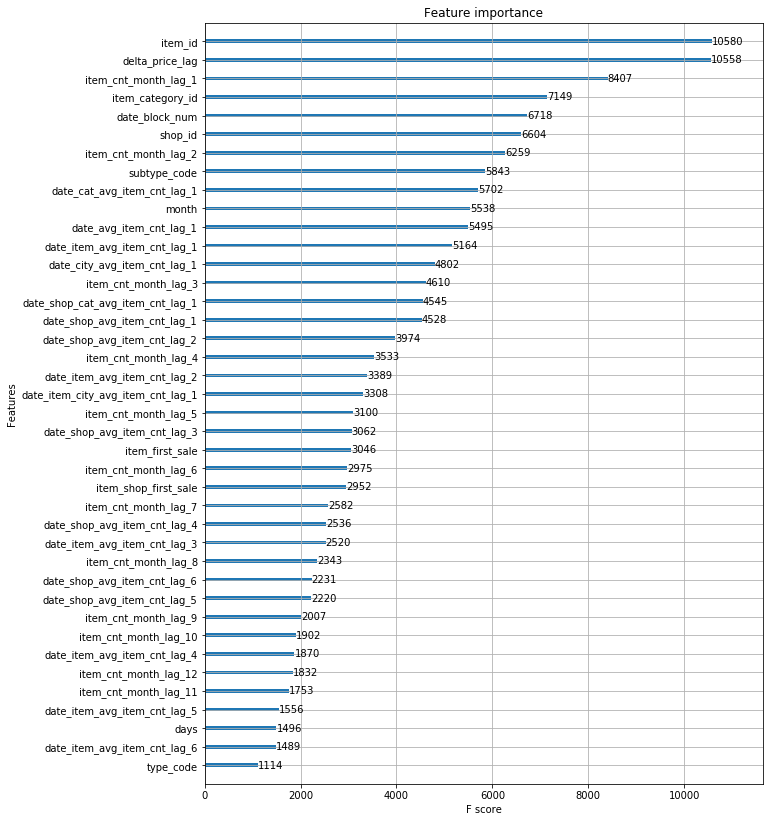

In [41]:
plot_features(model, (10,14))